# Bayesian Imputation

Real-world datasets often contain many missing values. In those situations, we have to either remove those missing data (also known as "complete case") or replace them by some values. Though using complete case is pretty straightforward, it is only applicable when the number of missing entries is so small that throwing away those entries would not affect much the power of the analysis we are conducting on the data. The second strategy, also known as [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)), is more applicable and will be our focus in this tutorial.

Probably the most popular way to perform imputation is to fill a missing value with the mean, median, or mode of its corresponding feature. In that case, we implicitly assume that the feature containing missing values has no correlation with the remaining features of our dataset. This is a pretty strong assumption and might not be true in general. In addition, it does not encode any uncertainty that we might put on those values. In below, we will construct a *Bayesian* setting to resolve those issues. In particular, given a model on the dataset, we will

+ create a generative model for the feature with missing value
+ and consider missing values as unobserved latent variables.

In [1]:
# first, we need some imports
import os

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import numpy as np, ops, random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

plt.style.use('seaborn')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

### Dataset

The data is taken from the competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) hosted on [kaggle](https://www.kaggle.com/). It contains information of passengers in the [Titanic accident](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic) such as name, age, gender,... And our target is to predict if a person is more likely to survive.

In [2]:
train_df = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv")
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Look at the data info, we know that there are missing data at `Age`, `Cabin`, and `Embarked` columns. Although `Cabin` is an important feature (because the position of a cabin in the ship can affect the chance of people in that cabin to survive), we will skip it in this tutorial for simplicity. In the datset, there are many categorical columns and two numerical columns `Age` and `Fare`. Let's first look at the distribution of those categorical columns:

In [3]:
for col in ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]:
    print(train_df[col].value_counts(), end="\n\n")

0    549
1    342
Name: Survived, dtype: int64

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64



### Prepare data

First, we will merge rare groups in `SibSp` and `Parch` columns together. In addition, we'll fill 2 missing entries in `Embarked` by the mode `S`. Note that we can make a generative model for those missing entries in `Embarked` but let's skip doing so for simplicity.

In [4]:
d = train_df.copy()
d.SibSp.clip(0, 1, inplace=True)
d.Parch.clip(0, 2, inplace=True)
d.Embarked.fillna("S", inplace=True)

Looking closer at the data, we can observe that each name contains a title. We know that age is correlated with the title of the name: e.g. those with Mrs. would be older than those with `Miss.` (in average) so it might be good to create that feature. The distribution of titles is:

In [5]:
d.Name.str.split(", ").str.get(1).str.split(" ").str.get(0).value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Lady.          1
Ms.            1
Mme.           1
Capt.          1
Don.           1
Sir.           1
Jonkheer.      1
the            1
Name: Name, dtype: int64

We will make a new column `Title`, where rare titles are merged into one group `Misc.`.

In [6]:
d["Title"] = d.Name.str.split(", ").str.get(1).str.split(" ").str.get(0).apply(
    lambda x: x if x in ["Mr.", "Miss.", "Mrs.", "Master."] else "Misc.")

Now, it is ready to turn the dataframe, which includes categorical values, into numpy arrays. We also perform standardization (a good practice for regression models) for `Age` column.

In [7]:
title_cat = pd.CategoricalDtype(categories=["Mr.", "Miss.", "Mrs.", "Master.", "Misc."], ordered=True)
embarked_cat = pd.CategoricalDtype(categories=["S", "C", "Q"], ordered=True)
age_mean, age_std = d.Age.mean(), d.Age.std()
data = dict(age=d.Age.pipe(lambda x: (x - age_mean) / age_std).values,
            pclass=d.Pclass.values - 1,
            title=d.Title.astype(title_cat).cat.codes.values,
            sex=(d.Sex == "male").astype(int).values,
            sibsp=d.SibSp.values,
            parch=d.Parch.values,
            embarked=d.Embarked.astype(embarked_cat).cat.codes.values,
            survived=d.Survived.values)

## Modelling

First, we would like to talk a bit about how to define improper priors in NumPyro. Consider the following logistic regression model,
```python
def model(x, y):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.param("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    numpyro.sample("obs", dist.Normal(a + b * x, sigma), obs=y)
```
. There we have some priors on sites `a`, `b`, and `sigma`. Now, assume that there is no apriori information on those sites, how can we define and get posterior samples of `a`, `b`, and `sigma`? In NumPyro, we can do it with `numpyro.param` primitives. An MCMC kernel will treat all `param` sites as they are having improper priors. For example, a corresponding linear regression model with no prior information is
```python
def model(x, y):
    a = numpyro.param("a", 0)
    b = numpyro.param("b", 1)
    sigma = numpyro.param("sigma", 1, constraint=constraints.positive)
    numpyro.sample("obs", dist.Normal(a + b * x, sigma), obs=y)
```

Another remark is: in MCMC context, the following models
```python
def model1():
    a = numpyro.sample("a", dist.Normal(0, 1))
```
and
```python
def model2():
    a = numpyro.param("a", 0)
    numpyro.sample("a_obs", dist.Normal(0, 1), obs=a)
```
are equivalent because both of them have
+ the same latent sites `a`,
+ and the same log densities `dist.Normal(0, 1).log_prob(a)`.

With those remarks in mind, we are ready to define a logistic regression model to predict survival chance given passengers' information.

In [8]:
def model(age, pclass, title, sex, sibsp, parch, embarked, survived=None):
    b_pclass = numpyro.sample("b_Pclass", dist.Normal(0, 1), sample_shape=(3,))
    b_title = numpyro.sample("b_Title", dist.Normal(0, 1), sample_shape=(5,))
    b_sex = numpyro.sample("b_Sex", dist.Normal(0, 1), sample_shape=(2,))
    b_sibsp = numpyro.sample("b_SibSp", dist.Normal(0, 1), sample_shape=(2,))
    b_parch = numpyro.sample("b_Parch", dist.Normal(0, 1), sample_shape=(3,))
    b_embarked = numpyro.sample("b_Embarked", dist.Normal(0, 1), sample_shape=(3,))

    # impute age by Title
    age_mu = numpyro.sample("age_mu", dist.Normal(0, 1), sample_shape=(5,))
    age_mu = age_mu[title]
    age_sigma = numpyro.sample("age_sigma", dist.Normal(0, 1), sample_shape=(5,))
    age_sigma = age_sigma[title]
    age_isnan = onp.isnan(age)
    age_nanidx = onp.nonzero(age_isnan)[0]
    if survived is not None:
        age_impute = numpyro.param("age_impute", np.zeros(age_isnan.sum()))
    else:  # we are making prediction
        age_impute = numpyro.sample("age_impute", dist.Normal(age_mu[age_nanidx], age_sigma[age_nanidx]))
    age = ops.index_update(age, age_nanidx, age_impute)
    numpyro.sample("age", dist.Normal(age_mu, age_sigma), obs=age)

    a = numpyro.sample("a", dist.Normal(0, 1))
    b_age = numpyro.sample("b_Age", dist.Normal(0, 1))
    logits = a + b_age * age

    logits = logits + b_title[title] + b_pclass[pclass] + b_sex[sex] \
        + b_sibsp[sibsp] + b_parch[parch] + b_embarked[embarked]
    if survived is None:
        probs = expit(logits)
        # record `probs` value in prediction
        numpyro.sample("probs", dist.Delta(probs))
    numpyro.sample("survived", dist.Bernoulli(logits=logits), obs=survived)

Note that in the model, the prior for `age` is `dist.Normal(age_mu, age_sigma)`, where the values of `age_mu` and `age_sigma` depend on `title`. Because there are missing values in `age`, we will encode those missing values in the latent parameter `age_impute`. Then we can replace `NaN` entries in `age` with the vector `age_impute`. Under the hood, similar to `model2` in the above remark, `age_impute` will have prior `dist.Normal(age_mu, age_sigma)`.

### Sampling

We will use MCMC with NUTS kernel to sample both regression coefficients and imputed values.

In [9]:
mcmc = MCMC(NUTS(model), 1000, 1000)
mcmc.run(random.PRNGKey(0), **data)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:37<00:00, 53.79it/s, 63 steps of size 6.75e-02. acc. prob=0.94] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
              a      0.11      0.83      0.10     -1.37      1.35    806.48      1.00
  age_impute[0]      0.24      0.84      0.22     -1.12      1.58   1921.09      1.00
  age_impute[1]     -0.12      0.87     -0.18     -1.58      1.28   1992.55      1.00
  age_impute[2]      0.37      0.81      0.39     -0.90      1.75   1914.70      1.00
  age_impute[3]      0.25      0.83      0.24     -1.23      1.47   1601.95      1.00
  age_impute[4]     -0.69      0.90     -0.67     -2.03      0.90   2558.34      1.00
  age_impute[5]      0.22      0.89      0.21     -1.16      1.71   2686.84      1.00
  age_impute[6]      0.41      0.80      0.41     -1.00      1.56   1813.22      1.00
  age_impute[7]     -0.64      0.88     -0.65     -2.12      0.75   2097.52      1.00
  age_impute[8]     -0.14      0.90     -0.13     -1.69      1.18   2614.57      1.00
  age_impute[9]      0.24      0.87      0.24     -1.

To double check that the assumption "age is correlated with title" is reasonable, let's look at the infered age by title. Recall that we performed standarization on `age`, so here we need to scale back to original domain.

In [10]:
age_by_title = age_mean + age_std * mcmc.get_samples()["age_mu"].mean(axis=0)
dict(zip(title_cat.categories, age_by_title))

{'Mr.': 32.412045,
 'Miss.': 21.793062,
 'Mrs.': 35.81341,
 'Master.': 4.6275177,
 'Misc.': 42.0792}

The infered result confirms our assumption that `Age` is correlated with `Title`:

+ those with `Master.` title has pretty small age (in other words, they are children in the ship) comparing to the other groups,
+ those with `Mrs.` title have larger age than those with `Miss.` title (in average).

We can also see that the result is similar to the actual statistical mean of `Age` given `Title` in our training dataset:

In [11]:
d.groupby("Title")["Age"].mean()

Title
Master.     4.574167
Misc.      42.384615
Miss.      21.773973
Mr.        32.368090
Mrs.       35.898148
Name: Age, dtype: float64

So far so good, we have many information about the regression coefficients together with imputed values and their uncertainties. Let's inspect those results a bit:

+ The mean value `-0.44` of `b_Age` implies that those with smaller ages have better chance to survive.
+ The mean value `(1.11, -1.07)` of `b_Sex` implies that female passengers have higher chance to survive than male passengers.

## Prediction

In NumPyro, we can use [Predictive](http://num.pyro.ai/en/stable/utilities.html#numpyro.infer.util.Predictive) utility for making predictions from posterior samples. Let's check how well the model performs on the training dataset. In this case, we will predict the chance to survive of each passenger (in other words, the `probs` values).

In [12]:
posterior = mcmc.get_samples().copy()
survived = data.pop("survived")
survived_probs = Predictive(model, posterior).get_samples(random.PRNGKey(1), **data)["probs"]
((survived_probs.mean(axis=0) >= 0.5).astype(np.uint8) == survived).sum() / survived.shape[0]

DeviceArray(0.8260382, dtype=float32)

This is a pretty good result using a simple logistic regression model.

Now comes to the test set, which also contains missing data in `Age` feature. We can't use `age_impute` from posterior samples because it is specific to the training set. So we need to marginalize them from the joint posterior distribution first:

In [13]:
posterior.pop("age_impute", None);

Then we will use the generative model for `age`, which is `dist.Normal(age_mu, age_sigma)`, to generate missing values for the test set:
```python
def model(age, ...):
    ...
    age_isnan = onp.isnan(age)
    age_nanidx = onp.nonzero(age_isnan)[0]
    age_impute = numpyro.sample("age_impute", dist.Normal(age_mu[age_nanidx], age_sigma[age_nanidx]))
```

All ingredients are ready for making prediction. We just need to perform the same data transformation process as the train set and use `Predictive` utility as before.

In [14]:
test_df = pd.read_csv("https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv")
d = test_df.copy()
d["Title"] = d.Name.str.split(", ").str.get(1).str.split(" ").str.get(0).apply(
    lambda x: x if x in ["Mr.", "Miss.", "Mrs.", "Master."] else "Misc.")
test_data = dict(age=d.Age.pipe(lambda x: (x - age_mean) / age_std).values,
                 pclass=d.Pclass.values - 1,
                 title=d.Title.astype(title_cat).cat.codes.values,
                 sex=(d.Sex == "male").astype(int).values,
                 sibsp=d.SibSp.clip(0, 1).values,
                 parch=d.Parch.clip(0, 2).values,
                 embarked=d.Embarked.astype(embarked_cat).cat.codes.values)

survived_probs = Predictive(model, posterior).get_samples(random.PRNGKey(2), **test_data)["probs"]
d["Survived"] = (survived_probs.mean(axis=0) >= 0.5).astype(np.uint8)

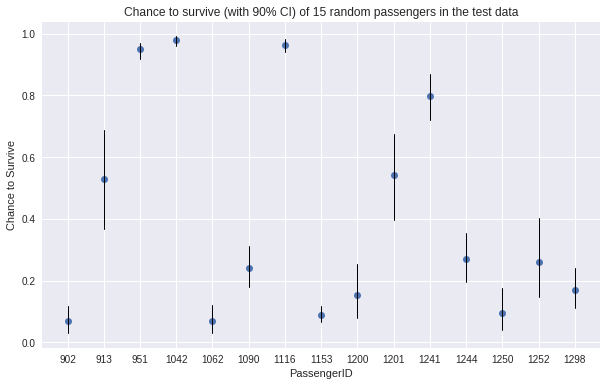

In [15]:
onp.random.seed(0)
num_passengers = 15
sample_idx = onp.random.choice(range(d.shape[0]), num_passengers, replace=False)
sample_idx.sort()

plt.figure(figsize=(10, 6))
plt.plot(survived_probs.mean(0)[sample_idx], "o")
plt.xticks(ticks=range(num_passengers), labels=d.PassengerId.iloc[sample_idx], rotation=0)

p_mu = np.mean(survived_probs, axis=0)[sample_idx]
p_ci = np.percentile(survived_probs, q=(5, 95), axis=0)[:, sample_idx]
for i in range(num_passengers):
    plt.plot(np.repeat(i, 2), p_ci[:, i], "k", lw=1)

plt.xlabel("PassengerID")
plt.ylabel("Chance to Survive")
plt.title("Chance to survive (with 90% CI) of {} random passengers in the test data".format(num_passengers))
plt.show()

## References

1. McElreath, R. (2016). Statistical Rethinking: A Bayesian Course with Examples in R and Stan.
2. Kaggle competition: [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)